# **Will they stay or will they go? Predicting employee attrition and improving models with synthetic data**
---

## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an HR related problem (although ficticious data)
4. Build a `streamlit` app

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` Age `
* ` Attrition `
* ` BusinessTravel `
* ` DailyRate `
* ` Department `
* ` DistanceFromHome `
* ` Education `
* ` EducationField `
* ` EmployeeCount `
* ` EmployeeNumber `
* ` EnvironmentSatisfaction `
* ` Gender `
* ` HourlyRate `
* ` JobInvolvement `
* ` JobLevel `
* ` JobRole `
* ` JobSatisfaction `
* ` MaritalStatus `
* ` MonthlyIncome `
* ` MonthlyRate `
* ` NumCompaniesWorked `
* ` Over18 `
* ` OverTime `
* ` PercentSalaryHike `
* ` PerformanceRating `
* ` RelationshipSatisfaction `
* ` StandardHours `
* ` StockOptionLevel `
* ` TotalWorkingYears `
* ` TrainingTimesLastYear `
* ` WorkLifeBalance `
* ` YearsAtCompany `
* ` YearsInCurrentRole `
* ` YearsSinceLastPromotion `
* ` YearsWithCurrManager `

# **The main problems**
When looking at employee data you may not have millions of employees. When  building a model often you need a lot of data. This is a potential problem.

Alongside not having a lot of data to model with, the majority of people will most likely not leave if the company is satisfying employees. So in the data you'll have say 0-10% of employees leaving in the past 6 months from the set date and 90% will stay. This is an **imbalanced classification problem**.

A potential solution to the problem - **generate synthetic data**

Why?
1. It captures the characteristics of the original data
2. If the small volume class is the only one generated then the imbalanced problem and data volume disappears
3. You train with the synthetic data but don't use it when testing so you still obtain reliable evaluation metrics

# **Libraries**

In [29]:
from pycaret.classification import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps

# **Importing data**

In [75]:
# Read and output the top 5 rows
hr_data = pd.read_csv("HR Employee Attrition.csv")
hr_data.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

# **Visualising**
As mentioned the main problem with this dataset is a large class imbalance for the target feature `Attrition`. I will model the data with the imbalance to see how it performs but there may be a way to improve it, synthetic data generation.

The other features look somewhat normal except some which have zero variance hence will be ignored.

Target looks like classification


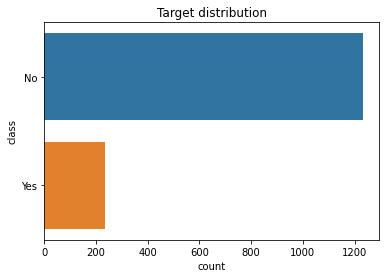

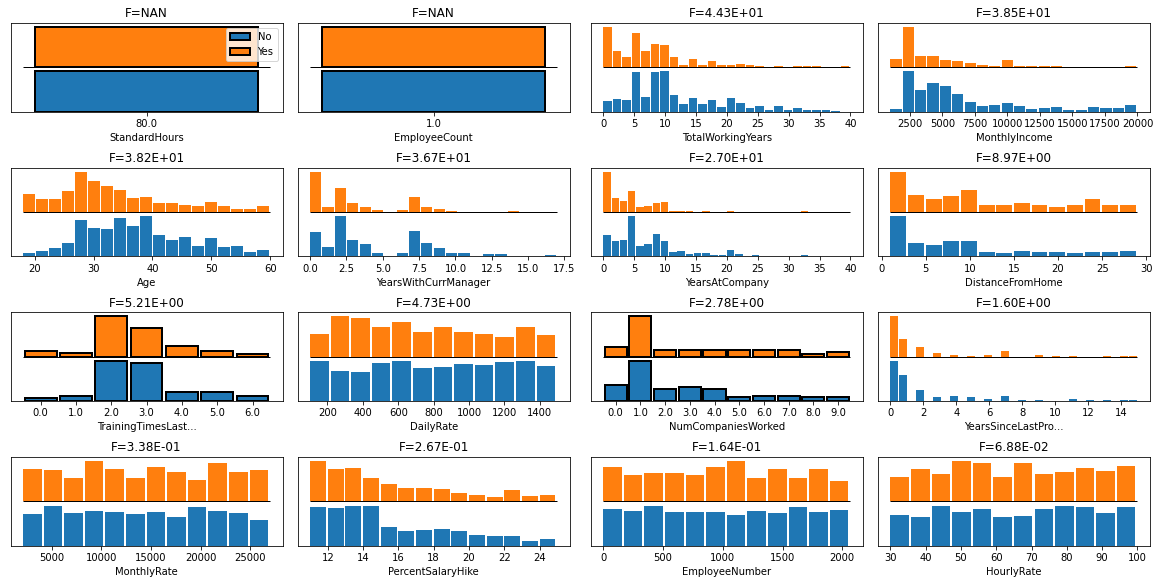

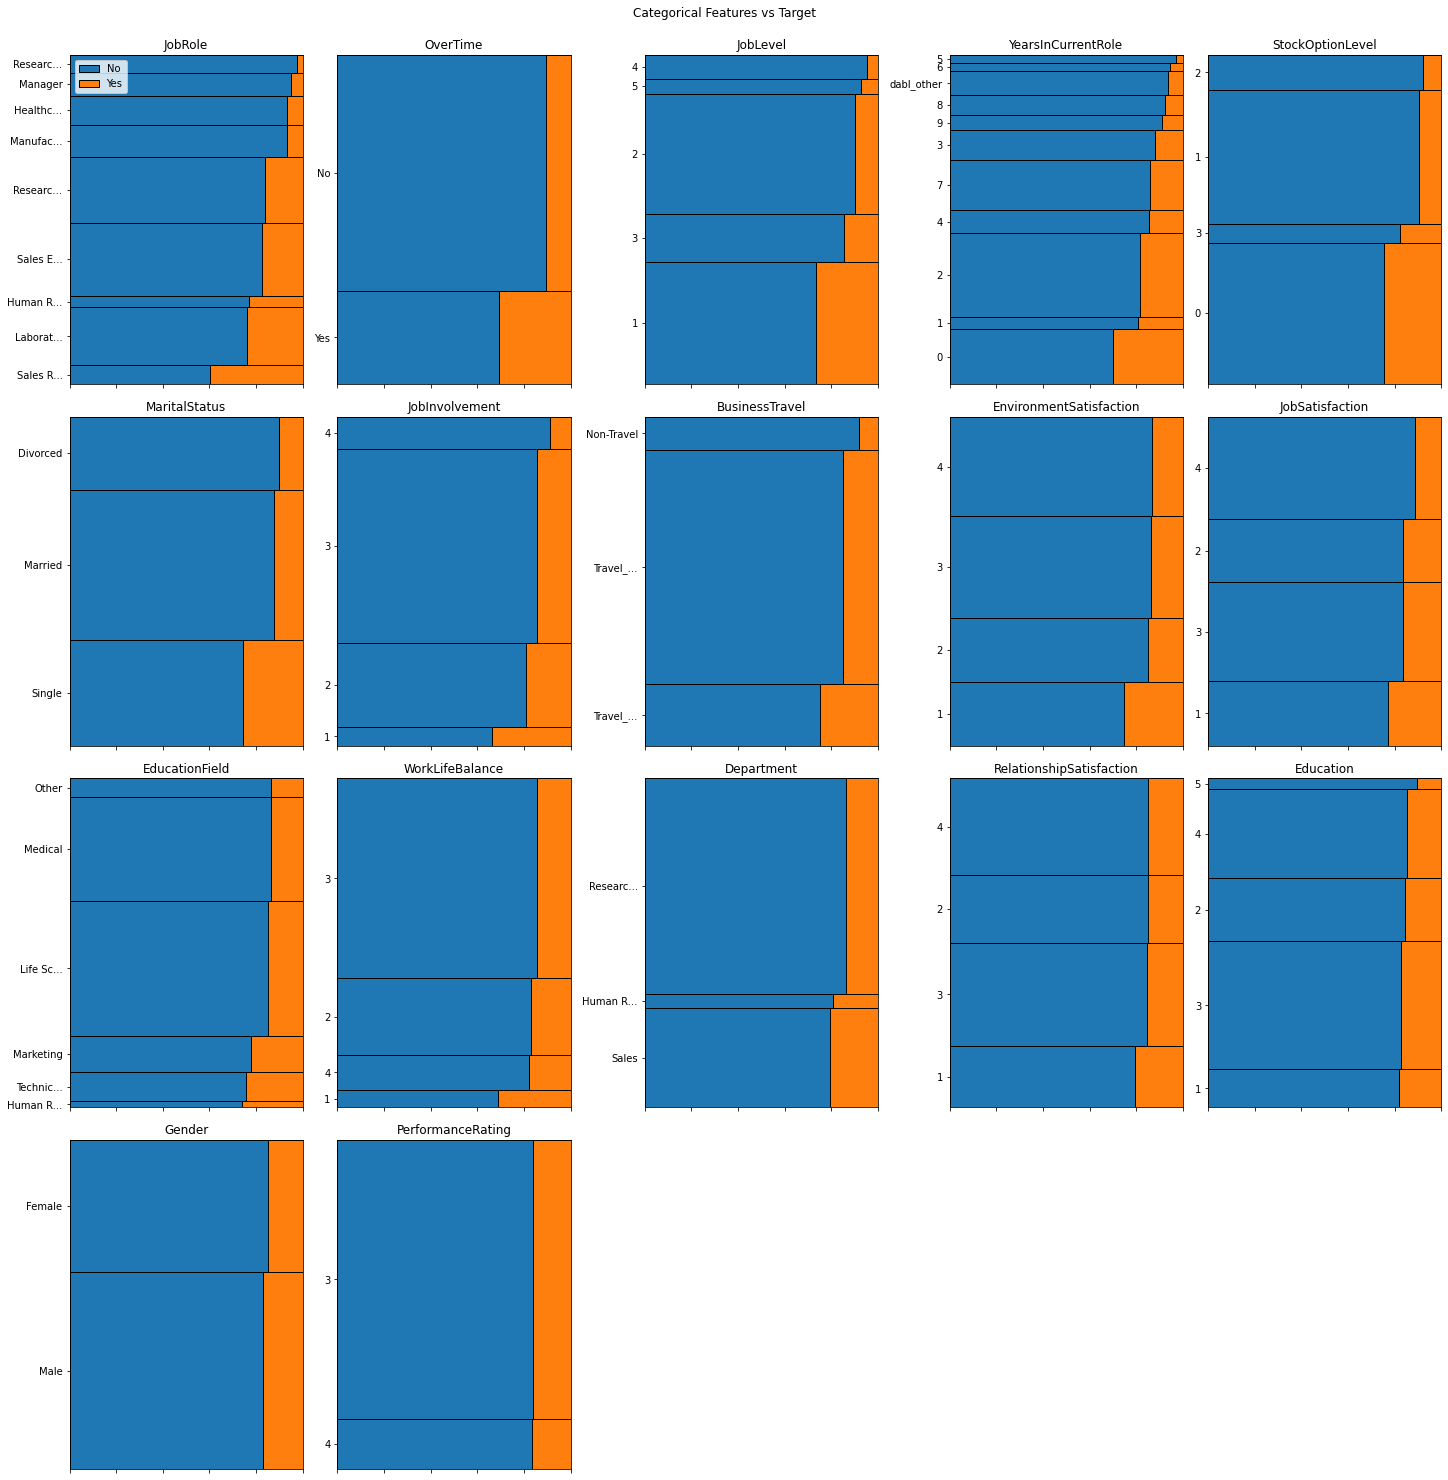

In [76]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
types = {"DistanceFromHome" : "continuous", "EmployeeCount" : "continuous",
         "HourlyRate" : "continuous", "MonthlyRate" : "continuous", 
         "NumCompaniesWorked" : "continuous", "PercentSalaryHike" : "continuous",
         "StandardHours" : "continuous", "TotalWorkingYears" : "continuous", 
         "YearsAtCompany" : "continuous", "YearsSinceLastPromotion" : "continuous",
         "YearsWithCurrManager" : "continuous", "TrainingTimesLastYear" : "continuous",
         "Age" : "continuous", "DailyRate" : "continuous", "MonthlyIncome" : "continuous"}

db.plot(hr_data, y = "Attrition", type_hints = types, plot_pairwise = False)

# **First modelling w/original data**
I'll use `Pycaret` to model the data given it's easy of use and speed. It can handle a lot of the preprocessing, modelling, evaluation and interpretation. Given the dataset is ~1.5k rows the processing isn't too intensive but if it increased in size thankfully Pycaret has GPU functionality.

Ordinal features need to have their levels known and ordered using a dictionary which can quickly be done.

In [77]:
ord_levels = ['StockOptionLevel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 
              'Education', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

# Print unique values of the ordinal features
for feat in ord_levels:
  print(feat, hr_data[feat].unique())

StockOptionLevel [0 1 3 2]
EnvironmentSatisfaction [2 3 4 1]
JobInvolvement [3 2 4 1]
JobSatisfaction [4 2 3 1]
Education [2 1 4 3 5]
PerformanceRating [3 4]
RelationshipSatisfaction [1 4 2 3]
WorkLifeBalance [1 3 2 4]


A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [78]:
# Target feature
target = "Attrition"

# Continuous/numeric features
cont_feats = ["DistanceFromHome", "HourlyRate",  "DailyRate", "MonthlyIncome",
              "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike",
              "TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole",
              "YearsWithCurrManager", "TrainingTimesLastYear", "YearsSinceLastPromotion"]

# Ordinal features
ord_feats = {"StockOptionLevel" : ["0", "1", "2", "3"],
             "EnvironmentSatisfaction" : ["1", "2", "3", "4"],
             "JobInvolvement" : ["1", "2", "3", "4"],
             "JobSatisfaction" : ["1", "2", "3", "4"],
             "Education" : ["1", "2", "3", "4", "5"],
             "PerformanceRating" : ["3", "4"],
             "RelationshipSatisfaction" : ["1", "2", "3", "4"],
             "WorkLifeBalance" : ["1", "2", "3", "4"]}

# Categorical geatures
cat_feats = ["BusinessTravel", "Department", "EducationField", 
             "JobRole", "Gender", "JobLevel", "JobRole", 
             "MaritalStatus", "OverTime", "WorkLifeBalance"]

# Features to ignore
ignore = ["EmployeeNumber", "StandardHours", "EmployeeCount", "Over18"]

Now with the features initalised they can be fed into pycaret's `setup` function involving steps...
* Feed in data + features
* Normalize continuous features + use `minimax` as the normalization method
* Use stratified k folding on the data
* Remove features with low variance
* Split the data into 70:30 train:test

There a lot on offer but not everything is used here.

In [79]:
# Run pycaret setup
setup(hr_data, 
      target = target,
      train_size = 0.7, 
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True)

(      Age Attrition     BusinessTravel  DailyRate              Department  \
 0      41       Yes      Travel_Rarely       1102                   Sales   
 1      49        No  Travel_Frequently        279  Research & Development   
 2      37       Yes      Travel_Rarely       1373  Research & Development   
 3      33        No  Travel_Frequently       1392  Research & Development   
 4      27        No      Travel_Rarely        591  Research & Development   
 ...   ...       ...                ...        ...                     ...   
 1465   36        No  Travel_Frequently        884  Research & Development   
 1466   39        No      Travel_Rarely        613  Research & Development   
 1467   27        No      Travel_Rarely        155  Research & Development   
 1468   49        No  Travel_Frequently       1023                   Sales   
 1469   34        No      Travel_Rarely        628  Research & Development   
 
       DistanceFromHome  Education EducationField  EmployeeCou

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [80]:
compare_models(sort = "AUC")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1373, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

So `Logistic Regression` is looking promising for `AUC` but `Recall` is not high, regardless I'll build a model on this. As shown below each fold's metrics are shown and the average from them.

In [82]:
lr = create_model("lr") # Create the gradient boosting classifier

Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

In [74]:
tune_model(lr, optimize = "AUC", n_iter = 30, search_library = "optuna", search_algorithm = "tpe")

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.043502974197018235, loss='deviance',
                           max_depth=3, max_features=0.7078363911025718,
                           max_leaf_nodes=None,
                           min_impurity_decrease=3.8863060095241816e-05,
                           min_impurity_split=None, min_samples_leaf=5,
                           min_samples_split=6, min_weight_fraction_leaf=0.0,
                           n_estimators=284, n_iter_no_change=None,
                           presort='deprecated', random_state=3900,
                           subsample=0.8476428167440917, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# **How to potentially solve this problem**
So the `lr` model isn't the best. Hyperparameter tuning wasn't great.

More data seems to be preached a lot but what if you can't? **GENERATE IT**.

The problem is making sure the data generated shares similar characteristics as the original data. Thankfully this can be evaluated.

I've decided to generate synthetic data only for people that have left in the last 6 months i.e. `Attrition == "Yes"` to lessen the class imbalance.

# **Generating synthetic data**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [38]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 80, max = 400),
          'batch_size' : hp.IntHyperParam(min = 1, max = 100),
          'embedding_dim' : hp.IntHyperParam(min = 1, max = 100),
          'gen' : hp.IntHyperParam(min = 1, max = 1000),
          'dim_gen' : hp.IntHyperParam(min = 1, max = 1000)
        }))

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [44]:
best_score = float('-inf') # Keep track of best score
tracker = 0 # Keep track of how many loops have completed
best_params = 0
real = hr_data[hr_data["Attrition"] == "Yes"] # Filter to only those employees that left

## TRAINING LOOP START ##
for _ in range(75):

  # Increment the tracker
  tracker += 1

  # Every 5 loops output the tracker
  if tracker % 5 == 0:
    print(tracker)

  # Get the hyperparameters for this loop
  proposal = tuner.propose(1)
  
  # Create the CopulaGAN
  # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
  model = CopulaGAN(primary_key = "EmployeeNumber", 
                    embedding_dim = proposal['embedding_dim'],
                    generator_dim = (proposal['gen'], proposal['gen']),
                    discriminator_dim = (proposal['dim_gen'], proposal['dim_gen']),
                    batch_size = proposal['batch_size'] * 10,
                    epochs = proposal['epochs'])
  
  # Fit the CopulaGAN
  model.fit(real)
  
  # Create 600 rows of data
  synth_data = model.sample(600, max_retries = 300)
  
  # Evaluate the synthetic data against the real data
  score = evaluate(synthetic_data = synth_data, real_data = real)
  print(score)
  # If the new hyperparameters beat the best ones, store them along with the score
  if score > best_score:
    best_params = proposal
    best_score = score

  # Record the hyperparameters and score      
  tuner.record(proposal, score)

## TRAINING LOOP END ##


print('Best score obtained: ', best_score)
print('Best parameters: ', best_params)

-47.633820484393176
-5796.539557530075
-479.50640492865944
-749.780606389268
5
-4795.8606421005625
-3444.422667709829
-14.488210191561604
-1464.3818517050545
-17.20626480866808
10
-12.946537639939109
-15.770079391817493
-599.7504328666288
-41.46574112524474
-914.055444340129
15
-1399.5690820214454
-4674.413111946011
-4003.65109441033
-44.887020754636595
-725.1931074926533
20
-113.21367511665818
-11.646650591302091
-4095.0316046112007
-72.48611927340797
-567.7084672036985
25
-143.48717299292082
-14.151906452116028
-2861.6429161578812
-2358.4048491497338
-2024.5023186389144
30
-170.59015748888697
-198.46122665615945
-200.29347527543803
-14.544540547698192
-174.65232328854637
35
-74.21718177115818
-472.16512901961687
-10.049783615976658
-2780.7375905618865
-3049.8499248932844
40
-227.37991026765104
-1122.2565586720475
-19.042543647080794
-10.778611243914035
-19.490955087517488
45
-73.25594159996064
-40.523632473505536
-568.6018853645367
-73.4422542559987
-2606.032848044636
50
-451.6774213

In [45]:
model.save('best_copula.pkl')

In [46]:
synth_data.to_csv("synth_data.csv", index = False)

So after 75 loops the overall score is 0.81 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [83]:
# Load synth data in
synth_data = pd.read_csv("synth_data.csv")

# Split real data into training + test set
train, test, target_train, target_test = train_test_split(hr_data.drop("Attrition", axis = 1), hr_data["Attrition"], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["Attrition"] = target_train
test["Attrition"] = target_test

# Add the 600 synthetic rows of data to training data + remove dataset column
input = pd.concat([train, synth_data])

In [84]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", input.shape)
print("Testing size (real:", test.shape)

Training size (real): (882, 35)
Training size (fake + real): (1482, 35)
Testing size (real: (588, 35)


In [85]:
for feat in list(ord_feats.keys()):
  print(feat, input[feat].unique())

StockOptionLevel [0 1 2 3 4]
EnvironmentSatisfaction [2 3 1 4 0 5]
JobInvolvement [3 2 4 1]
JobSatisfaction [4 2 3 1 5 0]
Education [4 2 3 1 5]
PerformanceRating [3 4 5]
RelationshipSatisfaction [4 2 1 3 5 0]
WorkLifeBalance [2 3 4 1]


In [86]:
ord_feats = {"StockOptionLevel" : ["0", "1", "2", "3", "4"],
             "EnvironmentSatisfaction" : ["0", "1", "2", "3", "4", "5"],
             "JobInvolvement" : ["1", "2", "3", "4"],
             "JobSatisfaction" : ["0", "1", "2", "3", "4", "5"],
             "Education" : ["1", "2", "3", "4", "5"],
             "PerformanceRating" : ["3", "4", "5"],
             "RelationshipSatisfaction" : ["0", "1", "2", "3", "4", "5"],
             "WorkLifeBalance" : ["1", "2", "3", "4"]}

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [87]:
# Run pycaret setup w/synthetic data
setup(input, 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)

(      Age     BusinessTravel  DailyRate              Department  \
 442    36         Non-Travel        635                   Sales   
 319    32      Travel_Rarely        588                   Sales   
 772    56  Travel_Frequently       1240  Research & Development   
 1053   57      Travel_Rarely        405  Research & Development   
 424    57      Travel_Rarely        210                   Sales   
 ...   ...                ...        ...                     ...   
 595    32      Travel_Rarely       1068  Research & Development   
 596    64      Travel_Rarely        248  Research & Development   
 597    61      Travel_Rarely       1130  Research & Development   
 598    73      Travel_Rarely       1366                   Sales   
 599    50  Travel_Frequently       1179  Research & Development   
 
       DistanceFromHome  Education    EducationField  EmployeeCount  \
 442                 10          4           Medical              1   
 319                  8          2  Tech

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [88]:
compare_models(sort = "AUC")

A gradient boosting classifier was decided upon.

In [71]:
gbc = create_model("lr") # Create the gradient boosting classifier

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

In [72]:
final_gbc = finalize_model(gbc)

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.